# Amazon Reviews Sentiment Analysis

In this project, we will take a closer look at the [Amazon Review Data (2018)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) dataset provided by the University of California San Diego and perform sentiment analysis on the reviews.

We opted for this dataset, because it is the largest publicly available dataset of Amazon reviews. It contains a total of 233.1 million reviews spanning May 1996 - July 2014.

While it is great to have such large amounts of data at ones disposal, it also comes with its own set of challenges. Throughout this project, we will explore the dataset, analyze different aspects of it and try to find ways to deal with the challenges that arise.

This document will adhere to the following structure:

1. [Prerequisites](#1-prerequisites)
2. [Data Loading](#2-data-loading)
3. [Data Preparation](#3-data-preparation)
4. [Data Analysis](#4-data-analysis)
    1. [Star Rating and Polarity](#41-star-rating-and-polarity-analysis)
    2. [Subjectivity Analysis](#42-subjectivity-analysis)
    3. [Feature Analysis](#43-feature-analysis)
    4. [Star Rating Prediction](#44-star-rating-prediction)
5. [Final Remarks](#5-final-remarks)
6. [Lessons Learned](#6-lessons-learned)
7. [Work Distribution](#7-work-distribution)

## 1. Prerequisites

### Python Environment

For this project, we will be using a set of Python libraries that are not included in the default Python environment. To create and manage an according Python environment, we use the Python library `poetry`. It can itself be installed as a python package, for example using `pip`:

In [ ]:
%%bash
pip install poetry

Once it is installed and available via the command line, we can create our environment using the following command:

In [ ]:
%%bash
poetry install --no-root

The command creates a new Python environment, which can then be used to run this notebook.

### Spark

Throughout this notebook we will be utilizing [Spark](https://spark.apache.org/) on top of the [Hadoop Distributed File System (HDFS)](https://hadoop.apache.org/) in order to process the large amounts of data we will be working with. Therefore, in order to run this notebook, you will need to have access to a running Spark instance. Since we are working directly on the machine which is running Spark, we will be using the following Spark configuration:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
            .master('local[*]') \
            .config("spark.driver.memory", "12g") \
            .config("spark.executor.memory", "12g") \
            .config("spark.memory.offHeap.enabled", "true") \
            .config("spark.memory.offHeap.size","24g") \
            .config("spark.driver.maxResultSize", "24g") \
            .getOrCreate()

It uses the local Spark instance as the master node and sets the memory limits according to our machines specifications. If you are running this notebook on a different machine, you will need to change the configuration accordingly.

## 2. Data Loading

For this project, we will be using the [Amazon Review Data (2018)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) dataset provided by the University of California San Diego. It consists of a total number of 233.1 million Amazon reviews written between May 1996 and Oct 2018 across 29 product categories. The dataset is available in the form of two JSON files for each product category, with each line in a file representing a JSON object. One file contains the reviews and the other contains the metadata for the products.

In [ ]:
%%bash
categories=("AMAZON_FASHION" "All_Beauty" "Appliances" "Arts_Crafts_and_Sewing" "Automotive" "Books" "CDs_and_Vinyl" "Cell_Phones_and_Accessories" "Clothing_Shoes_and_Jewelry" "Digital_Music" "Electronics" "Gift_Cards" "Grocery_and_Gourmet_Food" "Home_and_Kitchen" "Industrial_and_Scientific" "Kindle_Store" "Luxury_Beauty" "Magazine_Subscriptions" "Movies_and_TV" "Musical_Instruments" "Office_Products" "Patio_Lawn_and_Garden" "Pet_Supplies" "Prime_Pantry" "Software" "Sports_and_Outdoors" "Tools_and_Home_Improvement" "Toys_and_Games" "Video_Games")
data_links=()
meta_links=()

for category in "${categories[@]}"
do
    data_links+=("https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/$category.json.gz")
    meta_links+=("https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_$category.json.gz")
done

mkdir -p /data/json/
wget -P /data/json/ "${data_links[@]}" "${meta_links[@]}"

gunzip /data/json/*.gz

With the above script, we download the data and the metadata files for each category, store them in the `/data/json/` directory and unzip them. The resulting JSON files amount to a total of almost 300GB of data.

## 3. Data preparation

Now that we have downloaded these huge files, we cannot simply load them into memory and start working with them. One way of dealing with this problem is to use [Spark](https://spark.apache.org/) on top of the [Hadoop Distributed File System (HDFS)](https://hadoop.apache.org/), which allows us to distribute the data and the computations with the data. Therefore, the following steps require a Spark and Hadoop installation on the machine.

### Rename fields

In [ ]:
%%bash
sed -i -e 's/:":/":/g' /data/json/*.json

sed -i -e 's/"size":/"_size":/g' /data/json/meta_AMAZON_FASHION.json
sed -i -e 's/"size":/"_size":/g' /data/json/meta_Clothing_Shoes_and_Jewelry.json

Before we begin to work with the data using Spark, we have to rename some fields in the JSON files, because their names are not compatible with Spark DataFrames.

Some of the fields contain a `:` at the end of their name, which was likely introduced by some mistake in the data collection process and is not allowed in Spark. We remove the `:` from the field names with the first command.

There are also fields called `size` in the metadata files of the categories `AMAZON_FASHION` and `Clothing_Shoes_and_Jewelry`, which is a reserved keyword in Spark. Therfore, we rename these fields to `_size`.

### Join data and metadata

In [2]:
import pyspark.pandas as ps
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType, ArrayType, LongType

/home/tobias.grantner/.cache/pypoetry/virtualenvs/tu-dopp-ws23-OrQDfWK4-py3.9/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


24/01/23 00:58:51 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Now we are ready to start working with the data in spark, we can import the necessary libraries.

In [10]:
categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances', 'Arts_Crafts_and_Sewing', 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']

Since the original data is partitioned into two files for each category, we need an array of the names of all categories called `categories` in order to work with the data.

In [3]:
schema = StructType([
    StructField('asin', StringType()),
    StructField('image', ArrayType(StringType())),
    StructField('overall', DoubleType()),
    StructField('reviewText', StringType()),
    StructField('reviewTime', StringType()),
    StructField('reviewerID', StringType()),
    StructField('reviewerName', StringType()),
    StructField('style', StructType([
        StructField('Color', StringType()),
        StructField('Color Name', StringType()),
        StructField('Design', StringType()),
        StructField('Flavor', StringType()),
        StructField('Format', StringType()),
        StructField('Item Package Quantity', StringType()),
        StructField('Package Quantity', StringType()),
        StructField('Package Type', StringType()),
        StructField('Pattern', StringType()),
        StructField('Scent Name', StringType()),
        StructField('Size', StringType()),
        StructField('Size Name', StringType()),
        StructField('Style', StringType()),
        StructField('Style Name', StringType()),
    ])),
    StructField('summary', StringType()),
    StructField('unixReviewTime', LongType()),
    StructField('verified', BooleanType()),
    StructField('vote', StringType()),
])

Our goal is to combine all the available data into a single (yet distributed) file. However, the structure of the data files is slightly different for each category, which leads to problems when we try to combine them. Therefore, we first have to unify the structure of the data files, which we define as the Spark struct `schema`.

In [ ]:
for category in categories:
    print(f'Processing {category}')

    data = ps.read_json(f'/data/json/{category}.json', schema=schema, index_col=['reviewerID', 'asin'])

    meta = ps.read_json(f'/data/json/meta_{category}.json', index_col='asin')
    meta = meta.drop(['similar_item', 'details', 'tech1', 'tech2'], axis=1)

    df = data.reset_index().join(meta, on='asin')
    df.reset_index(inplace=True)
    df.set_index(['reviewerID', 'asin'], inplace=True)
    df['category'] = category
    df.to_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin'])

    print(f'Finished {category}')

We can then simply read the data and metadata files for each category into a Pandas on Spark DataFrame, join them and write the resulting DataFrame to a parquet file.

Pandas on Spark is an abstraction of Spark DataFrames, which can be used the same way the popular Python library `pandas` is used, with the added benefit of being able to distribute the data and the computations with the data.

The parquet file is a columnar storage format, which is optimized for distributed data processing. It is also the default file format for Spark DataFrames.

### Concatenate categories

Now that we have all the data in a clean structure and stored in an efficient file format, we can work with it well. However, since we still have a separate file for each category, we don't want to have to work with all these files separately. Therefore, we concatenate all the parquet files into a single file.

In [14]:
df_list = [ps.read_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin']) for category in categories]
df = ps.concat(df_list)
df.to_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])

To join the files, we can simply read the separate parquet files into DataFrames, concatenate them and write the resulting DataFrame to a new parquet file.

In [3]:
df = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
df.shape

(230139802, 25)

As we can see, the resulting file indeed contains the around 230 million Amazon reviews we want to work with.

## 4. Data Analysis

### 4.1. Star Rating and Polarity Analysis
#### *Are Amazon product reviews generally more positive/negative for certain categories compared to others?*
A reliable indication of whether a customer appreciates a particular product is evident in their positive review, while dissatisfaction is often reflected in negative feedback. However, discerning what defines a good review versus a bad one poses a challenge. Can the star rating alone serve as a definitive indicator of a customer's satisfaction with a product? In this section of the notebook, our focus is on comparing the star ratings and sentiment values across various product categories, aiming to shed light on the relationship between these two evaluative metrics.

Moreover, the comparison between different categories enables the identification of products that resonate more with the general customer base. It also provides insights into the reviewing behavior of customers across diverse product categories. For instance, are customers in the tech sector, who purchase electronics and software, more inclined to leave negative reviews? Maybe, due to the products being prone to errors compared to, for example, customers who buy eBooks and Gift Cards?

By exploring these aspects, we aim to gain a nuanced understanding of how customers perceive and review products across different categories, thereby contributing to a more comprehensive analysis of the dataset.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg, concat_ws, mean, stddev, var_samp, expr
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import SparkSession
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Not in Requirements, poetry add vaderSentiment
from textblob import TextBlob

##
## Set this flag to True, if you want to generate all the .parquets used in this part of the notebook
## If set to False, the notebook tries to just read them in from the /data folder
##
generate = False
print('This run will generate all the .parquet files!') if generate else print('This run will read the .parquet files from /data!')

data = spark.read.parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
print(f"Shape of the DataFrame: ({data.count()}, {len(data.columns)})")

This run will read the .parquet files from /data!


Shape of the DataFrame: (230139802, 27)


#### Outlier Detection and Handling
Interestingly, the dataset contains 9 rows, all having an overall star rating of 0 stars. However, when considering the vast size of the entire dataset, which consists of 230,139,802 rows, these 9 entries are realistically insignificant. As a result, we have excluded them from our analysis. Including them would only serve to complicate the plots and data without providing any meaningful additional information gain. Additionally, looking at the review summary of those rows, classifies them even more as outliers, because the text 'Goog Read' would typically not result in a rating of 0 stars.

In [ ]:
data[data['overall'] == 0.0][['overall', 'summary', 'reviewText']].show()
data = data.filter(data['overall'] != 0.0)

+-------+--------------------+--------------------+
|overall|             summary|          reviewText|
+-------+--------------------+--------------------+
|    0.0|Blurb from inside...|The fundamental s...|
|    0.0|Old world knowled...|From the back cov...|
|    0.0|              Rating|The story was goo...|
|    0.0|A pretty little book|A pretty little b...|
|    0.0|Vividly colored r...|This is the artis...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|                Wow!|I cried throughou...|
|    0.0|            Readable|A lot of mistakes...|
+-------+--------------------+--------------------+



#### Star Ratings Analysis
To address the question of whether Amazon reviews exhibit a tendency to be more positive or negative across different categories, we chose to compare them using two metrics. The first metric examines the overall star rating of the reviews, investigating for example whether certain categories receive more 5-star reviews than others and examining the general distribution of star ratings.

##### Data Preparation
After handling outliers, a star rating can now range from 1 star to 5 stars, with 5 stars representing the highest rating. To facilitate meaningful comparisons across different categories, we computed the total number of reviews for each possible star rating and the average rating for each category.

In [ ]:
##
## Groups by Category and counts the number of ratings per Star Rating
## Returned Columns: 'category', 'stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5', 'number_of_reviews', 'average_rating'
## Returned Dataframe is a Pandas Dataframe
##
def reduce_to_cat_stars(data):
    long_df = data.groupBy('category', 'overall').count()
    df = long_df.groupBy('category').pivot('overall').sum("count")

    for i in range(1, 6):
        df = df.withColumnRenamed(f"{i}.0", f"stars_{i}")

    df = df.withColumn('number_of_reviews', col('stars_1') + col('stars_2') + col('stars_3') + col('stars_4') + col('stars_5'))
    df = df.withColumn('average_rating', (col('stars_1') + col('stars_2') * 2 + col('stars_3') * 3 + col('stars_4') * 4 + col('stars_5') * 5) / col('number_of_reviews'))

    df = df.orderBy('category')
    return df.toPandas()


data_cat_stars = reduce_to_cat_stars(data)
data_cat_stars

,category,stars_1,stars_2,stars_3,stars_4,stars_5,number_of_reviews,average_rating
0,AMAZON_FASHION,107080,64718,97031,149331,465476,883636,3.906940
1,All_Beauty,39261,20293,29555,52687,229549,371345,4.112093
2,Appliances,59627,20734,30652,75476,416288,602777,4.274209
3,Arts_Crafts_and_Sewing,210232,120994,198200,361840,1984651,2875917,4.317731
4,Automotive,734047,329578,503860,1065868,5356813,7990166,4.249263
5,Books,2088314,1850688,3835225,9557650,33979736,51311613,4.393248
6,CDs_and_Vinyl,165396,133374,277854,700943,3265802,4543369,4.489727
7,Cell_Phones_and_Accessories,1382543,654327,860610,1517552,5648223,10063255,3.933553
8,Clothing_Shoes_and_Jewelry,2271737,1804553,2982765,5707951,19525093,32292099,4.189458
9,Digital_Music,43108,23551,57347,179929,1280147,1584082,4.660555


##### Plot and Review the Results
The following plot illustrates the percentage of reviews for each category corresponding to a specific star rating. Additionally, the categories are arranged in order of their average star rating, facilitating the identification of significant differences in star rating distribution. For instance, Gift Cards, Digital Music, and CDs and Vinyl exhibit relatively high average star ratings with a substantial number of 5-star reviews, in contrast to categories like Software products.

This disparity may arise from the nature of products such as Gift Cards and Digital Music, where issues are less likely to occur. Gift cards usually function seamlessly upon purchase, minimizing the likelihood of dissatisfaction leading to negative reviews. Similarly, with Digital Music and CDs and Vinyl, the ease of access to online music and the likelihood that purchasers genuinely enjoy the songs they buy contribute to higher satisfaction levels.

On the other hand, Software faces challenges like a high error rate, installation difficulties, and configuration complexities, which may result in a less favorable experience for users.

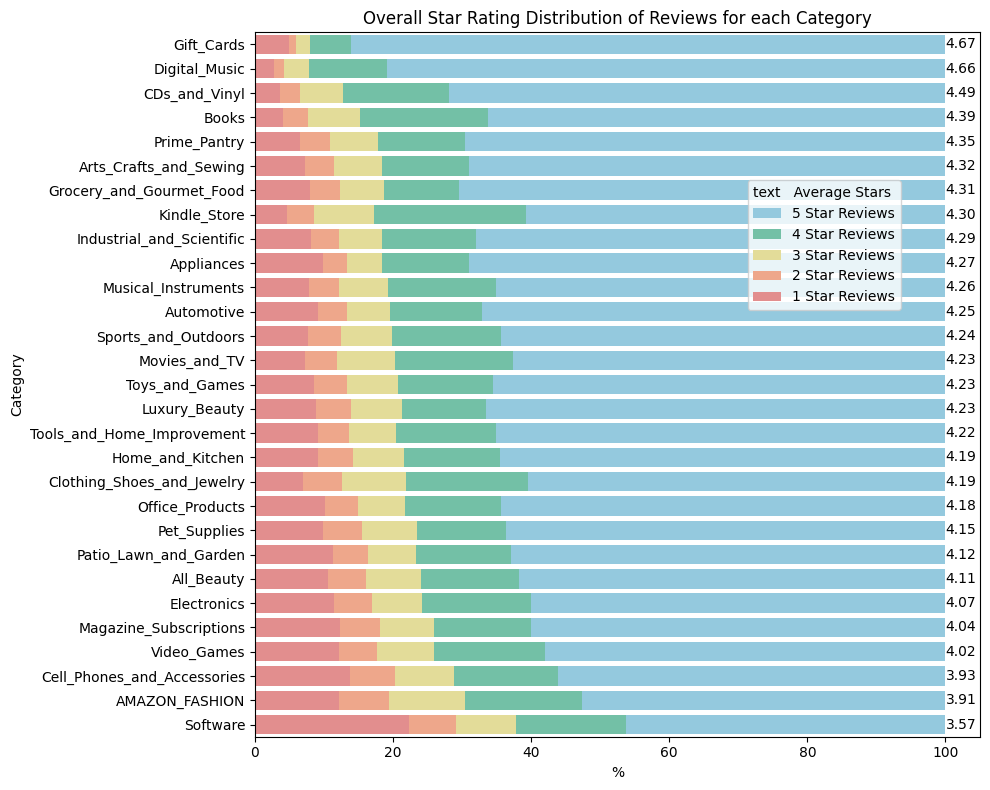

In [ ]:
def plot_cat_stars(df_cat_stars):
    # Calculate comulative values
    com_df_cat_stars = df_cat_stars.copy()
    for i in range(1, 5):
        com_df_cat_stars[f'stars_{i+1}'] += com_df_cat_stars[f'stars_{i}']
    # Normalize and convert to Percent
    for i in range(1, 6):
        com_df_cat_stars[f'stars_{i}'] *= 100 / com_df_cat_stars[f'stars_5']

    com_df_cat_stars = com_df_cat_stars.sort_values(by=['average_rating'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='stars_5', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[0], label='5 Star Reviews')
    sns.barplot(x='stars_4', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[1], label='4 Star Reviews')
    sns.barplot(x='stars_3', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[2], label='3 Star Reviews')
    sns.barplot(x='stars_2', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[3], label='2 Star Reviews')
    sns.barplot(x='stars_1', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[4], label='1 Star Reviews')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_stars.iterrows():
        ax1.text(row['stars_5'], i, f'{row["average_rating"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Overall Star Rating Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Stars', alignment='left')

    # Show the plot
    plt.show()

plot_cat_stars(data_cat_stars)

In [ ]:
def outlier_detection(title, df, col_name):
    print(title)
    # print(df[col_name].describe())

    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    # Outliers
    print(df[(df[col_name] < Q1 - 1.5 * IQR) | (Q3 + 1.5 * IQR < df[col_name])][['category', col_name]])

outlier_detection('Average Star Rating Outliers', data_cat_stars, 'average_rating')

Average Star Rating Outliers
         category  average_rating
9   Digital_Music        4.660555
11     Gift_Cards        4.671970
24       Software        3.570175


#### Sentiment Analysis
As a second metric, we opted to examine the distribution of sentiment values within both the summary and review text of the reviews. Our goal was to compare two distinct approaches: one utilizing the polarity compound score from the [Vader Sentiment Analysis tool](https://vadersentiment.readthedocs.io/en/latest/) and the polarity score from the [TextBlob Text Processing tool](https://textblob.readthedocs.io/en/dev/). As described in the article [Sentiment Analysis with TextBlob and Vader](https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/), TextBlob struggles a bit with negative sentences, especially with negations, which needs to be taken into account for the further analysis.

Regrettably, the Vader Sentiment Analyzer is computationally intensive, leading us to perform the analysis on a sample of the data. Conversely, TextBlob is more efficient in terms of computation, allowing us to calculate sentiment scores for the entire dataset. A comparative analysis was conducted between the two tools to better assess the overall data situation.

##### Sampling the Dataset

The resulting sample contains either a fixed fraction or a minimum number of rows for each category. Given the considerable variation in sizes among different categories—such as 51 million reviews for Books and approximately 150,000 for Gift Cards in the dataset—using a fixed fraction for sampling presents challenges. Opting for a fixed fraction might underrepresent certain categories, making analysis challenging as the fraction for a category may consist of very few rows. Conversely, selecting too large a fraction renders the sample unwieldy and impractical for conducting Vader Analysis.

Choosing a fixed number of samples per category is also not advisable, as it would result in an extremely low fraction for larger categories, underrepresenting them and making predictions untrustworthy. To maintain comparability with the sentiment analysis and star ratings, we aimed to closely replicate the star rating distribution of the original dataset. This involved selecting a fraction for each star rating based on the number of rows within that rating. The slight deviations in averages and variances of the sample from the original data result from the way pySpark handles sampling, providing a sample that is close but not exactly the specified fraction. 

A comparison between the sample and the original dataset is done later in this section.

In [ ]:
categories = sorted([row['category'] for row in data.select('category').distinct().collect()])

DISCLAIMER: Do not forget to set the 'generate'-flag in the top cell of this section, if you wish to generate all .parquets from scratch.

In [ ]:
##
## Creates a sample of each category based on the star ratings, it therefore tries to follow the distribution of the star ratings in the original dataset as closely as possible
##
def sample_for_sentiment(filename, spark_session, frac = 0.00001, min_per_cat = 1000, verbose = False):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        frac = max(frac, min_per_cat / rows_of_category.count())
        fractions = {stars: frac for stars in range(1, 6)}
        sampled_rows = rows_of_category.sampleBy('overall', fractions, seed=42)

        sampled_rows.write.parquet(filename, mode=mode)
        mode = 'append'

filename = '/data/question1_data_sample.parquet'
sample_for_sentiment(filename, spark) if generate else None
data_sample = spark.read.parquet(filename)
data_sample_cat_stars = reduce_to_cat_stars(data_sample)

To enhance the comparison between star ratings and sentiment values, we chose to categorize them into five groups, mirroring the five different star ratings. According to the Vader Sentiment Analyzer page, a compound score greater than 0.5 is generally considered positive, while a score lower than -0.5 is generally deemed negative. As for the TextBlob tool, no such predefined categorization was provided, so we applied the same criteria for both tools. Furthermore, we evenly distributed the intervals across the range of [-1, 1] to facilitate a clearer visualization of the data. It's important to note that in this analysis, a positive classification corresponds more to a positive tendency, and is not directly comparable to a positive classification of a three state model mentioned on the Vader webpage. 

In [ ]:
##
## Removes unnecaccary columns and adds column for the sentiment analysis
##
def reduce_to_sentiment(df, calculate_score, score_col):
    df = df.withColumn('text', concat_ws(' - ', col('summary'), col('reviewText')))
    df = df.withColumn(score_col, calculate_score(df['text']))

    df = df[['category', 'overall', 'verified', score_col]]
    calculate_sentiment = udf(lambda compound: 'very_positive' if compound >= 0.6 
                                else ('positive' if compound >= 0.2
                                else ('very_negative' if compound <= -0.6 
                                else ('negative' if compound <= -0.2
                                else 'neutral'))), StringType())
    df = df.withColumn("sentiment", calculate_sentiment(df[score_col]))
    return df

def write_sentiment_parque(filename, spark_session, calculate_score, score_col, verbose = False):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        sentiment_rows = reduce_to_sentiment(rows_of_category, calculate_score, score_col)

        sentiment_rows.write.parquet(filename, mode=mode)
        mode = 'append'

##### Data Preparation Vader Sentiment

In [ ]:
## New Columns: 'vader_compound', 'sentiment'
def reduce_to_vader_sentiment(df):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_vader_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_vader_sentiment.parquet'

data_sample_vader_sentiment = reduce_to_vader_sentiment(data_sample) if generate else None
data_sample_vader_sentiment.write.parquet(filename, mode = 'overwrite') if generate else None

data_sample_vader_sentiment = spark.read.parquet(filename)

##### Data Preparation TextBlob

In [ ]:
## New Columns: 'textblob_polarity', 'sentiment'
def reduce_to_textblob_sentiment(df):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_textblob_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_textblob_sentiment.parquet'

data_sample_textblob_sentiment = reduce_to_textblob_sentiment(data_sample) if generate else None
data_sample_textblob_sentiment.write.parquet(filename, mode = 'overwrite') if generate else None

data_sample_textblob_sentiment = spark.read.parquet(filename)

Because TextBlob Polarity Analysis is significantly faster than Vader Sentiment, we were able to conduct the analysis on the entire dataset.

In [ ]:
filename = '/data/question1_data_complete_textblob_sentiment.parquet'
write_textblob_sentiment(filename, spark) if generate else None
data_textblob_sentiment = spark.read.parquet(filename)

In [ ]:
##
## Groups by Category and counts the number of ratings per sentiment class
## Resulting Columns: 'category', 'very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'number_of_reviews', 'average_sentiment'
##
def reduce_to_cat_sentiment(data, score_col):
    long_df = data.groupBy('category', 'sentiment').count()
    df = long_df.groupBy('category').pivot('sentiment').sum("count")
    df = df.withColumn('number_of_reviews', col('very_negative') + col('negative') + col('neutral') + col('positive') + col('very_positive'))

    df = df.orderBy('category').toPandas()
    average_sentiment = data.groupBy("category").agg(avg(score_col).alias('average_sentiment')).toPandas().reset_index(drop=True)
    df = df.merge(average_sentiment, on='category', how='left')

    return df

data_sample_vader_cat_sentiment = reduce_to_cat_sentiment(data_sample_vader_sentiment, 'vader_compound')
data_sample_textblob_cat_sentiment = reduce_to_cat_sentiment(data_sample_textblob_sentiment, 'textblob_polarity')

data_textblob_cat_sentiment = reduce_to_cat_sentiment(data_textblob_sentiment, 'textblob_polarity')

##### Plot and Review the Results
As anticipated, the distribution among the very positive, positive, and neutral groups is quite uniform, suggesting that they share a as aforementioned equal interval range for sentiment scores. However, suprisingly the dataset contains only a minimal number of negative sentiment scores. More specifically, the TextBlob Polarity Analyzer identified a samall percentage of negative sentiment within the review data. This is likely due to TextBlob struggling to accurately classify negations. To address this limitation, we also conducted the Vader analysis, as aforementioned.

First and foremost, we must compare the sample to the entire dataset to ensure the sample holds a degree of significance. As evident from the data, the most significant differences between the mean and variance of the star ratings, as indicated by the columns mean_diff and var_diff, occur in categories with the lowest total number of ratings in the sample. It's worth noting that these numbers were already increased by the inclusion of the minimum rows per category parameter. Furthermore, the TextBlob sentiment shows only marginal absolute differences, reinforcing the conclusion that the sample is indeed somewhat significant.

In [ ]:
def compare_stats(data, textblob_data, sample, textblob_sample):
    summary_data = data.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_data = summary_data.merge(textblob_data[['category', 'average_sentiment']], on='category', how='left')
    summary_data.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    summary_sample = data_sample.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_sample = summary_sample.merge(textblob_sample[['category', 'average_sentiment']], on='category', how='left')
    summary_sample.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    result_df = summary_data.merge(summary_sample, on='category', how='inner', suffixes=('_data', '_sample'))
    
    result_df['mean_diff'] = (result_df['mean_data'] - result_df['mean_sample']).abs()
    result_df['var_diff'] = (result_df['var_data'] - result_df['var_sample']).abs()
    result_df['textblob_diff'] = (result_df['textblob_data'] - result_df['textblob_sample']).abs()
    result_df = result_df.sort_values(by=['category'], ascending=True).reset_index(drop=True)
    result_df = result_df.sort_index(axis=1)
    
    return result_df   

compare_stats(data, data_textblob_cat_sentiment, data_sample, data_sample_textblob_cat_sentiment)

,category,mean_data,mean_diff,mean_sample,n_data,n_sample,textblob_data,textblob_diff,textblob_sample,var_data,var_diff,var_sample
0,AMAZON_FASHION,3.906940,0.033510,3.873430,883636,1035,0.311714,0.004756,0.306958,2.011517,0.064324,2.075841
1,All_Beauty,4.112093,0.007246,4.104847,371345,1011,0.314065,0.004891,0.318957,1.855312,0.058436,1.913749
2,Appliances,4.274209,0.002091,4.276300,602777,1654,0.343185,0.001045,0.344230,1.694155,0.024376,1.718531
3,Arts_Crafts_and_Sewing,4.317731,0.011645,4.306086,2875917,7756,0.372555,0.000433,0.372988,1.484252,0.034169,1.518421
4,Automotive,4.249263,0.007609,4.256873,7990166,21571,0.360737,0.001051,0.361788,1.663165,0.004117,1.659048
5,Books,4.393247,0.003394,4.389853,51311621,137957,0.315036,0.000916,0.314119,1.092884,0.004636,1.097520
6,CDs_and_Vinyl,4.489727,0.013785,4.503512,4543369,12242,0.357439,0.000921,0.358360,0.985187,0.023146,0.962041
7,Cell_Phones_and_Accessories,3.933553,0.012434,3.945987,10063255,27086,0.325097,0.000552,0.324545,2.138930,0.026249,2.112682
8,Clothing_Shoes_and_Jewelry,4.189458,0.000554,4.190012,32292099,86705,0.343948,0.000048,0.343900,1.517789,0.006918,1.510871
9,Digital_Music,4.660555,0.014376,4.646179,1584082,4279,0.429375,0.006919,0.422456,0.712389,0.036165,0.748554


##### Comparison between TextBlob and Vader Sentiment 
Similar to the star ratings, we observe consistent categories at both ends of the spectrum. Gift cards and Digital Music continue to yield high customer satisfaction, resulting in positive reviews. Conversely, the Software category again encounters challenges, with only the Video Game category performing worse in terms of sentiment within the review Text and summary. However, this observation could be influenced by the TextBlob Analyzer. Upon examining both the sample and the original data, the values from the TextBlob analysis remain remarkably consistent. In contrast, the values from the Vader analysis show some deviation. The top categories are consistent, with Gift cards and Digital Music leading in positive sentiment. However, the Software category distinctly ranks lower in the spectrum according to the Vader analysis. Upon closer inspection, the graph of the Vader Analysis more closely aligns with the graph of the Star Ratings from the initial part of this section.

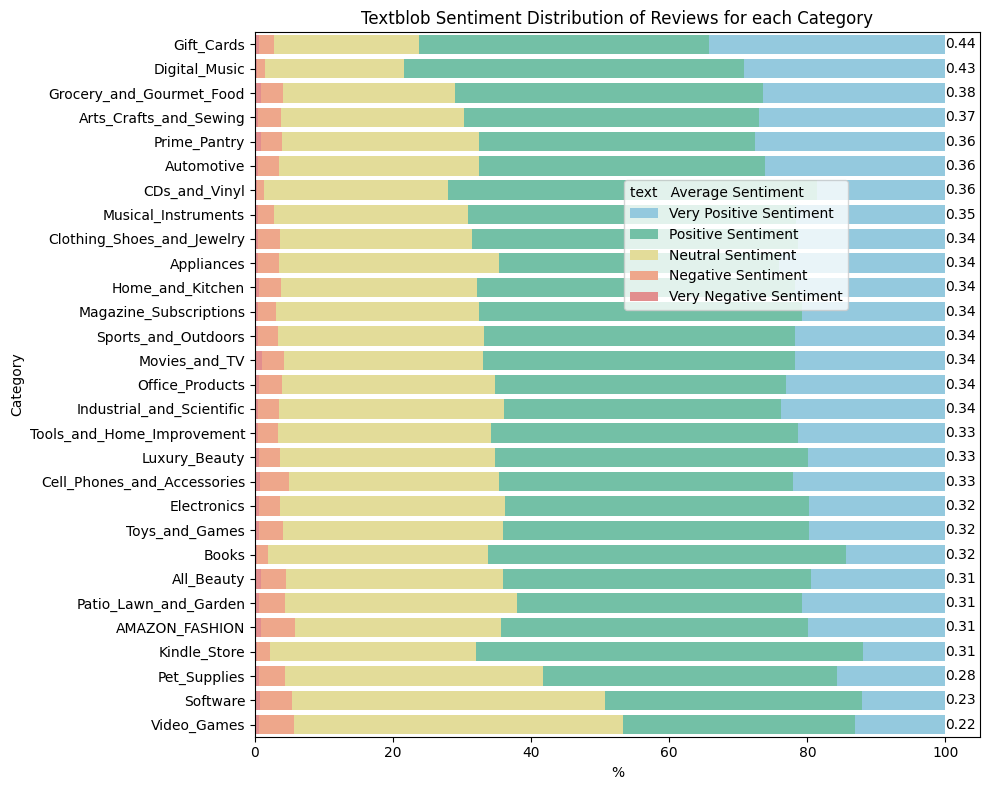

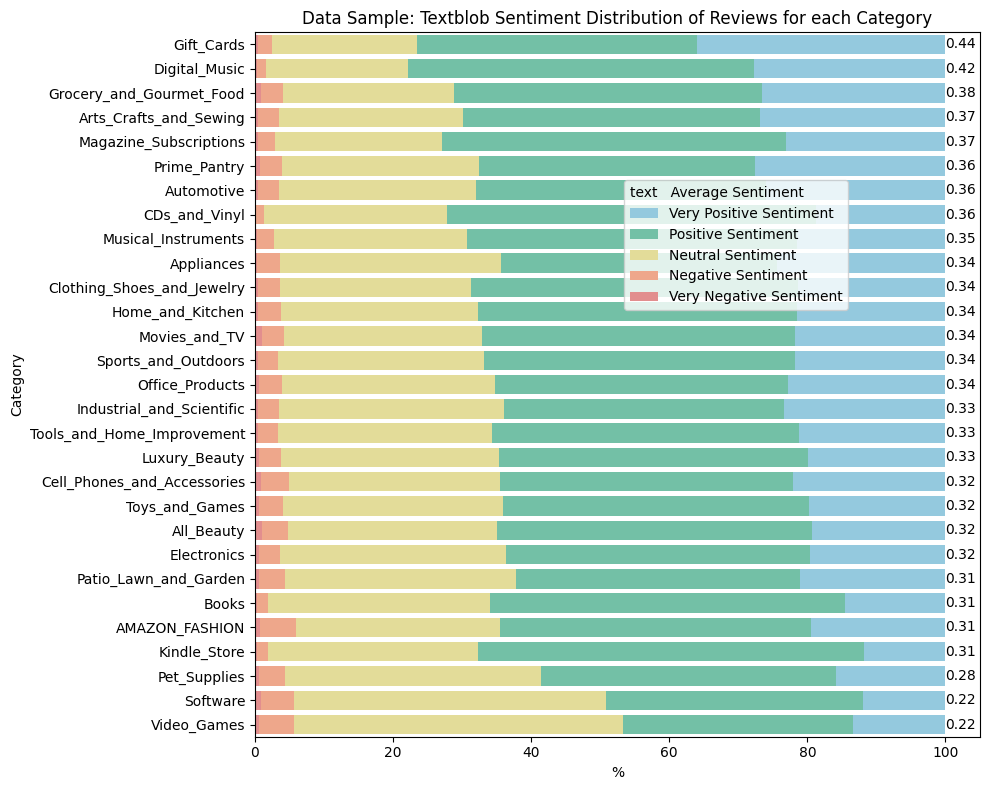

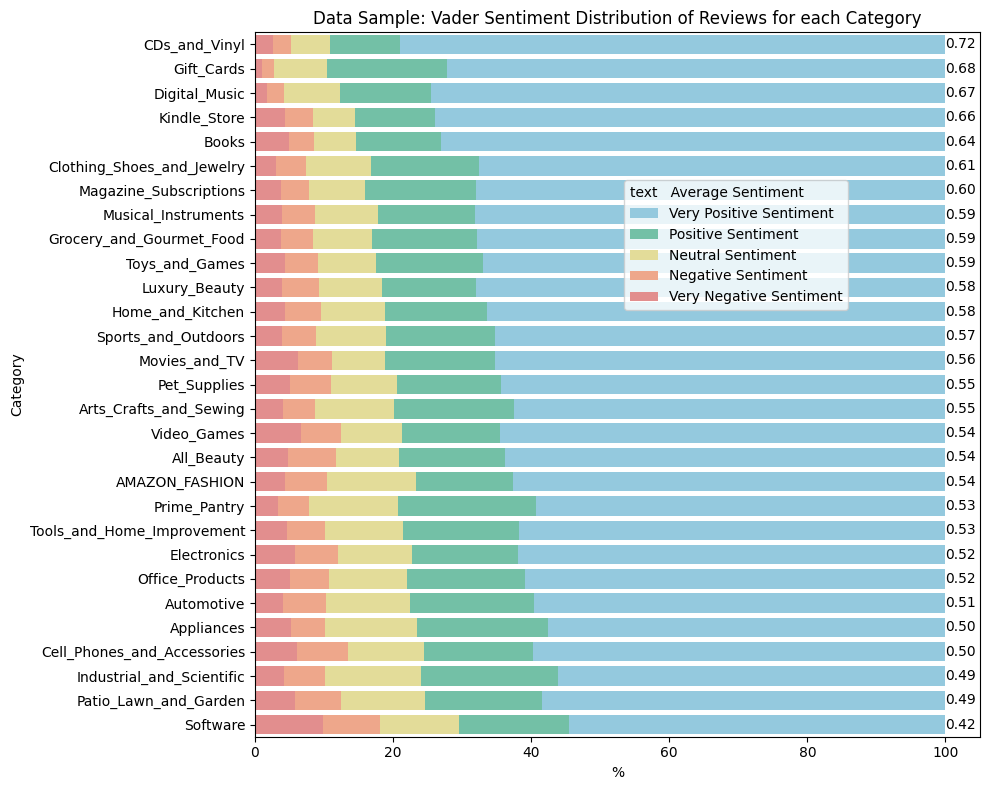

In [ ]:
def plot_cat_sentiment(title, df_cat_sentiment):
    # Calculate comulative values
    com_df_cat_sentiment = df_cat_sentiment.copy()
    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['average_sentiment'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='very_positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very Positive Sentiment')
    sns.barplot(x='positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='Positive Sentiment')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='Neutral Sentiment')
    sns.barplot(x='negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='Negative Sentiment')
    sns.barplot(x='very_negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very Negative Sentiment')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_positive'], i, f'{row["average_sentiment"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title(title)

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.5, 0.8), title='text   Average Sentiment', alignment='left')


    # Show the plot
    plt.show()

plot_cat_sentiment('Textblob Sentiment Distribution of Reviews for each Category', data_textblob_cat_sentiment)
plot_cat_sentiment('Data Sample: Textblob Sentiment Distribution of Reviews for each Category', data_sample_textblob_cat_sentiment)
plot_cat_sentiment('Data Sample: Vader Sentiment Distribution of Reviews for each Category', data_sample_vader_cat_sentiment)

In [ ]:
outlier_detection('Textblob Average Sentiment Outliers', data_textblob_cat_sentiment, 'average_sentiment')
outlier_detection('Data Sample - TextBlob Average Sentiment Outliers', data_sample_textblob_cat_sentiment, 'average_sentiment')
outlier_detection('Data Sample - Vader Average Sentiment Outliers', data_sample_vader_cat_sentiment, 'average_sentiment')

Textblob Average Sentiment Outliers
         category  average_sentiment
9   Digital_Music           0.429375
11     Gift_Cards           0.435075
24       Software           0.226293
28    Video_Games           0.221828
Data Sample - TextBlob Average Sentiment Outliers
         category  average_sentiment
9   Digital_Music           0.422456
11     Gift_Cards           0.438908
24       Software           0.223885
28    Video_Games           0.221733
Data Sample - Vader Average Sentiment Outliers
        category  average_sentiment
6  CDs_and_Vinyl           0.719027


#### Correlation between Star Rating and Sentiment
The following scatterplots suggest a correlation between sentiment and star rating values. Lower sentiment reviews tend to correspond to lower star ratings. Notably, the categories Giftcards, Digital Music and Software stand out as clear outliers in all three plots. Addressing a part of our question, as it is evident that there are notable differences between the categories concerning the average positivity of the reviews. 

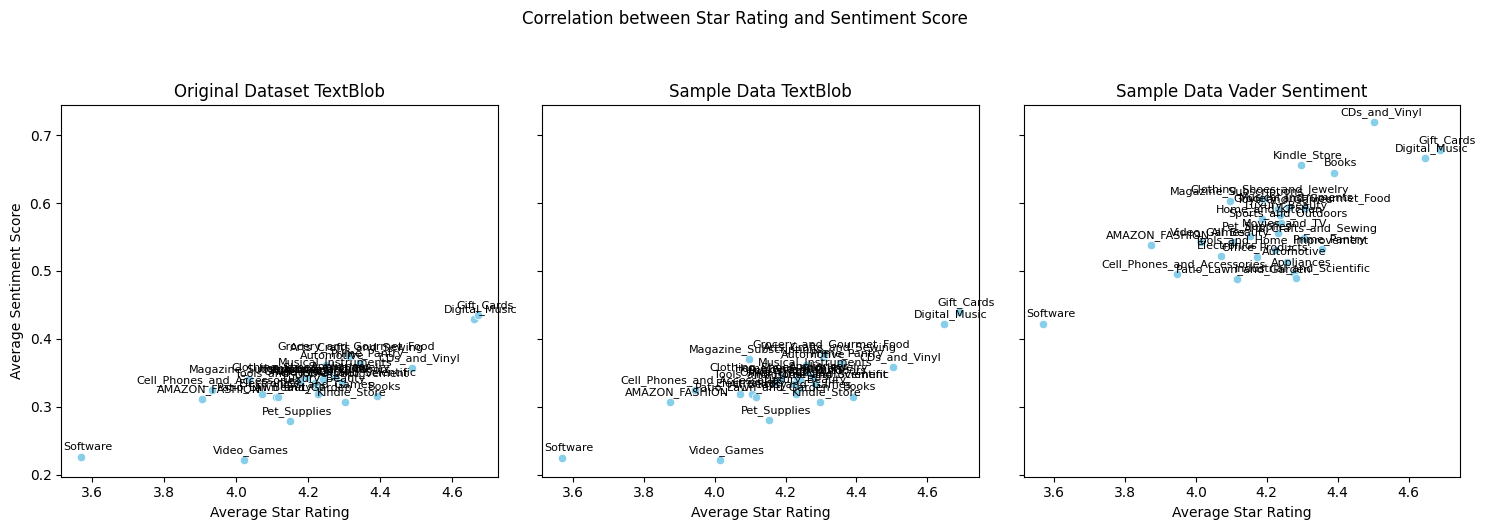

In [ ]:
def plot_correlation_stars_sentiment(title, df_stars, df_sentiment, ax):
    df_merged = df_stars.merge(df_sentiment, on='category', how='left')[['category', 'average_rating', 'average_sentiment']]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    sns.scatterplot(x='average_rating', y='average_sentiment', data=df_merged, ax=ax, color="#87CEEB")

    # Annotate each point with the category name
    for i, row in df_merged.iterrows():
        ax.annotate(row['category'], (row['average_rating'], row['average_sentiment']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)


    # Customize plot labels and title
    ax.set_xlabel('Average Star Rating')
    ax.set_ylabel('Average Sentiment Score')
    ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.suptitle('Correlation between Star Rating and Sentiment Score', y=1.05)
plot_correlation_stars_sentiment('Original Dataset TextBlob', data_cat_stars, data_textblob_cat_sentiment, axes[0])
plot_correlation_stars_sentiment('Sample Data TextBlob', data_sample_cat_stars, data_sample_textblob_cat_sentiment, axes[1])
plot_correlation_stars_sentiment('Sample Data Vader Sentiment', data_sample_cat_stars, data_sample_vader_cat_sentiment, axes[2])

# Tight layout and legend
plt.tight_layout()

# Show the plot
plt.show()


The plot illustrates the distribution of ratings within each sentiment classification, where the percentages are calculated within the respective sentiment class. This approach enables a more focused examination of differences within specific groups. It's worth noting that the distribution of the number of stars per rating is skewed. For instance, in the case of very negative sentiment, there are more 5-star reviews than 3-star reviews. Despite this skewness, a comparison of bars for each rating reveals clear patterns. The percentage of 5-star reviews is highest when associated with very positive sentiment, while the highest percentage of 1-star reviews is found in conjunction with very negative sentiment.

Similarly to the earlier observation regarding the alignment between Vader sentiment compound scores and star ratings, a similar pattern is evident in this analysis. Notably, each rating exhibits its largest bar within its corresponding sentiment subgraph.

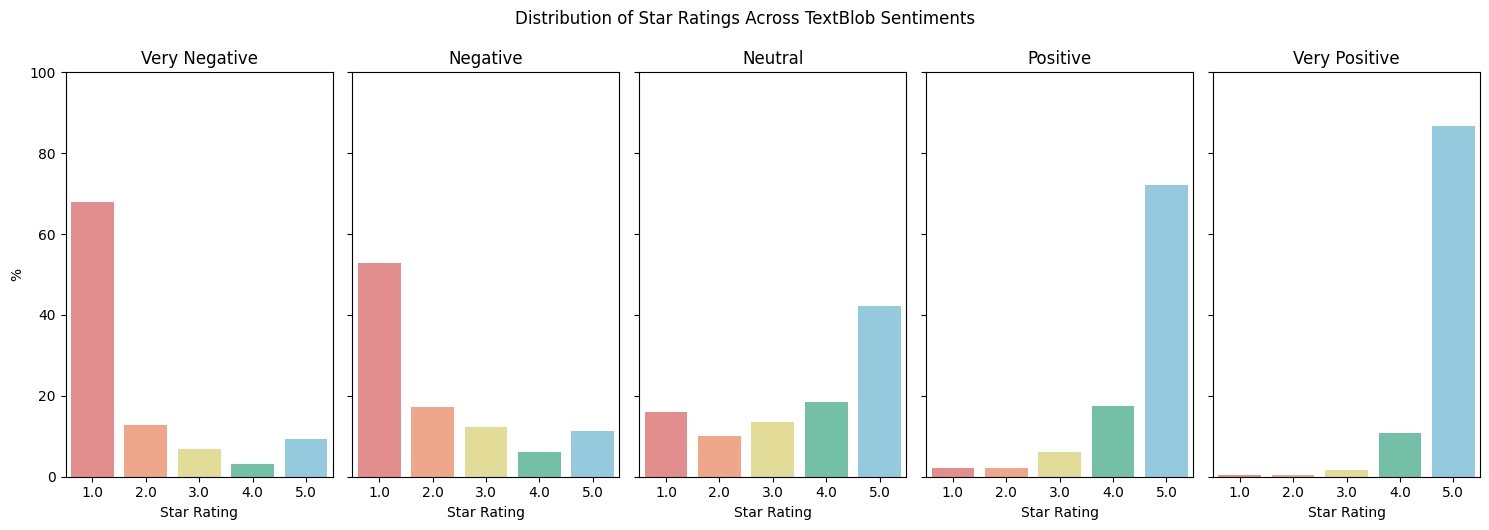

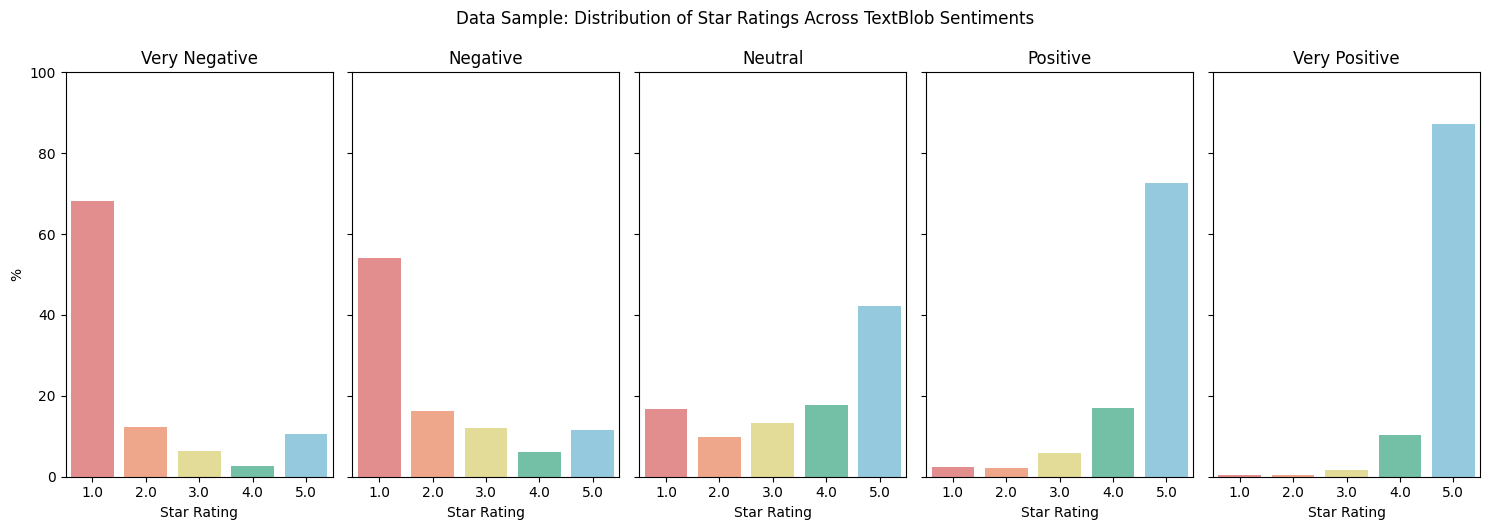

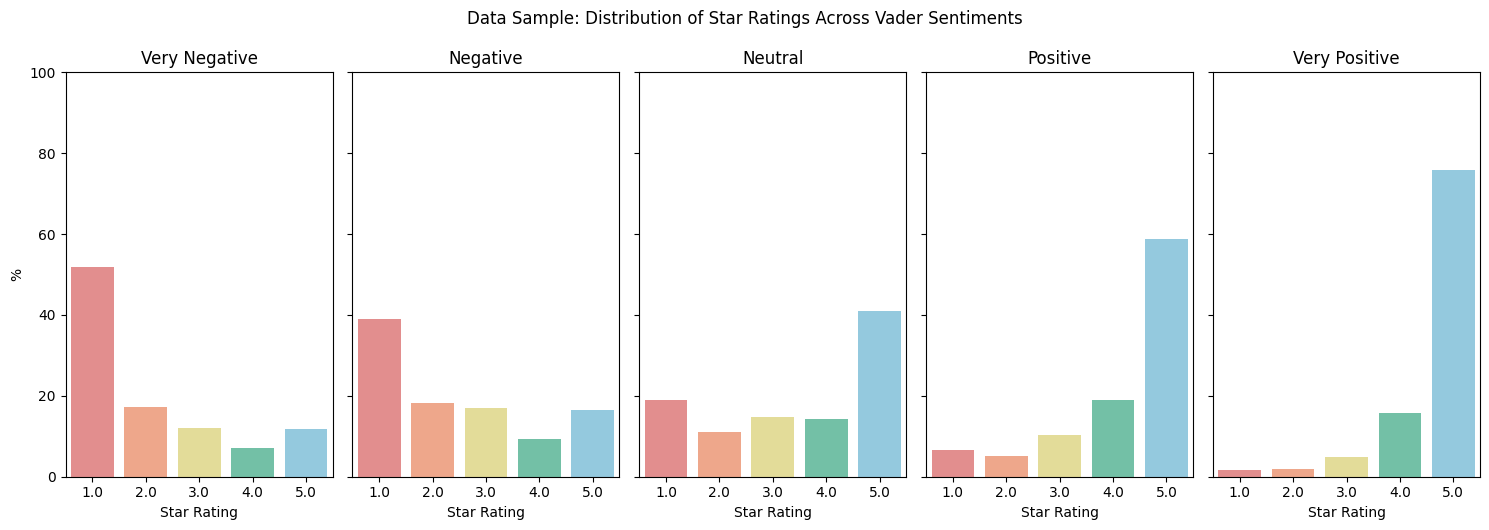

In [ ]:
def plot_hist_comparison(title, data_sentiment):
    long_df = data_sentiment.groupBy('overall', 'sentiment').count()
    df = long_df.groupBy('overall').pivot('sentiment').sum("count")
    df = df.orderBy('overall').toPandas()

    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    # Normalize and convert to Percent
    for i in range(0, 5):
        df[sentiments[i]] *= 100 / df[sentiments[i]].sum()

    # Pastel-toned colors
    pastel_palette = ["#F08080", "#FFA07A", "#F0E68C", "#66CDAA", "#87CEEB"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), sharey=True)
    for i, sentiment in enumerate(sentiments):
        sns.barplot(x='overall', y=sentiment, data=df, palette=pastel_palette, hue='overall', ax=axes[i], dodge=False)
        axes[i].set_title(sentiment.replace('_', ' ').title())
        axes[i].set_xlabel('Star Rating')
        axes[i].set_ylabel('%')
        axes[i].legend_.remove()
        axes[i].set_ylim(0, 100)

    # Tight layout and Title
    plt.tight_layout()
    # Set a single title for all plots
    fig.suptitle(title, y=1.05)

    # Show the plot
    plt.show()

plot_hist_comparison('Distribution of Star Ratings Across TextBlob Sentiments', data_textblob_sentiment)
plot_hist_comparison('Data Sample: Distribution of Star Ratings Across TextBlob Sentiments', data_sample_textblob_sentiment)
plot_hist_comparison('Data Sample: Distribution of Star Ratings Across Vader Sentiments', data_sample_vader_sentiment)

### 4.2 Subjectivity Analysis
#### *Are reviews more subjective for some categories of products than for others, based on sentiment analysis?*
This section discusses the role of subjectivity in feedback as an indicator of potential problems within a product or product category. It acknowledges the difficulty in categorizing reviews as subjective or objective. The exploration extends to understanding the relationship between the subjectivity of a summary and that of a reviewText, and whether one aspect holds greater importance than the other. The primary focus of this section of the notebook is to compare sentiment values across various product categories, with the goal of determining whether some categories are more prone to subjectivity than others.

Additionally, the comparison between different categories serves the purpose of identifying similar customer reactions to products within the same category. This comparative analysis provides insights into reviewing behavior across diverse product categories. An example is presented to illustrate the potential variance in objectivity between customers in the tech sector, dealing with electronics and software, versus customers in fashion-related categories where personal preferences significantly influence product evaluation.

By exploring these aspects, we aim to gain a understanding of how customers perceive and review products across different categories, thereby contributing to a more comprehensive analysis of the dataset.

#### Imports
This section contains all the imports needed to execute further cells.

In [ ]:
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg
from pyspark.sql.types import StringType, DoubleType
from textblob import TextBlob

#### Missing values Detection and Handling
Interestingly, the dataset contains 217,655 rows, containing no `reviewText` or `summary`. However, when considering the vast size of the entire dataset, which consists of 230,139,802 rows, these 217,655 entries are realistically insignificant. Even though, we do not remove them, but handle their abstinence during the sentiment analysis as described in the next chapter.

In [ ]:
data = spark.read.parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
data.filter(col("reviewText").isNull() | col("summary").isNull()).count()

217655

#### Perform sentiment analysis
To assess subjectivity, we utilized the subjectivity score from the [TextBlob Text Processing tool](https://textblob.readthedocs.io/en/dev/), ranging from 0 to 1, where 1 indicates high subjectivity and 0 signifies high objectivity. Our focus was on comparing the disparity between the `summary` and `reviewText`. Additionally, we categorized the subjectivity scores into four groups: `very_subjective, subjective, very_objective, objective`. The data was further classified based on an evenly distributed distribution between 0 and 1. We adopted this approach because determining a clear threshold for what qualifies as "very subjective" versus "subjective" is challenging without knowledge of the subjectivity score distribution and further domain knowledge. Outliers were set to 0, as we considered a missing reviewText or summary to be inherently very objective.

Given the relatively low computational intensity of TextBlob analysis, we conducted the the sentiment analysis on the entire dataset. Consequently, all categories were analyzed individually and subsequently merged for a comprehensive overview.

In [ ]:
def apply_sentiment_analysis(df):
    df = df[["category", "overall", "verified", "vote", "summary", "reviewText", "reviewTime"]]
    df = df.to_spark(index_col=["reviewerID", "asin"])

    calculate_subjectivity = udf(lambda x: TextBlob(x).subjectivity if x else 0, DoubleType())
    calculate_sentiment_subjectivity = udf(
        lambda subjectivity: "very_subjective" if subjectivity >= 0.75 
            else ("subjective" if subjectivity > 0.5 
            else ("very_objective" if subjectivity < 0.25 else "objective")),
        StringType(),
    )

    df = df.withColumn("reviewText-subjectivity", calculate_subjectivity(df["reviewText"]))
    df = df.withColumn("summary-subjectivity", calculate_subjectivity(df["summary"]))

    df = df[["category", "overall", "verified", "vote", "reviewTime", "reviewText-subjectivity", "summary-subjectivity"]]

    df = df.withColumn("reviewText-sentiment-subjectivity", calculate_sentiment_subjectivity(df["reviewText-subjectivity"]))
    df = df.withColumn("summary-sentiment-subjectivity", calculate_sentiment_subjectivity(df["summary-subjectivity"]))
    return df

In [ ]:
generate = False
if generate:
    for category in categories:
        df = ps.read_parquet(f"/data/{category}.parquet", index_col=["reviewerID", "asin"])
        data_sentiment = apply_sentiment_analysis(df)
        data_sentiment.write.parquet(f"/data/question1_{category}_transformed.parquet", mode="overwrite")

In [ ]:
mode = "overwrite"
if generate:
    for category in categories:
        df = spark.read.parquet(f"/data/question1_{category}_transformed.parquet")
        df.write.parquet("/data/data_question1.parquet", mode=mode)
        mode = "append"

In [ ]:
df = spark.read.parquet("/data/data_question2.parquet")
df.show(5)

+--------+-------+--------+----+-----------+-----------------------+--------------------+---------------------------------+------------------------------+
|category|overall|verified|vote| reviewTime|reviewText-subjectivity|summary-subjectivity|reviewText-sentiment-subjectivity|summary-sentiment-subjectivity|
+--------+-------+--------+----+-----------+-----------------------+--------------------+---------------------------------+------------------------------+
|   Books|    5.0|    true|NULL| 04 7, 2017|                    0.9|  0.8450000000000001|                  very_subjective|               very_subjective|
|   Books|    5.0|    true|NULL|01 11, 2016|                   0.75|                 1.0|                  very_subjective|               very_subjective|
|   Books|    5.0|   false|NULL|07 15, 2014|                    1.0|                 0.0|                  very_subjective|                very_objective|
|   Books|    4.0|   false|   4|10 24, 2011|    0.26666666666666666|  

#### Prepare data
Dealing with over 200 million data points is rather challenging; visualizing them is impossible. Therefore, to further answer question 2, we need to reduce and aggregate available data to only one record for each category. For this reason, we calculated the average subjectivity for each category and counted the absolute frequency of our newly introduced classes: `very_subjective, subjective, very_objective, objective`.

In [ ]:
def reduce_by_col(df, column, col_agg, groupBy="category"):
    df_reduced = df.groupBy(groupBy, column).agg(count("*").alias("count"))
    df_reduced = df_reduced.groupBy(groupBy).pivot(column).sum("count")
    df_reduced.fillna(0)
    df_reduced = df_reduced.withColumn("number_of_reviews", col("very_subjective") + col("subjective") + col("objective") + col("very_objective"))
    df_reduced_average = df.groupBy(groupBy).agg(avg(col_agg).alias("average_subjectivity"))
    df_reduced = df_reduced.join(df_reduced_average, groupBy, "inner")
    return df_reduced

df_reduced_reviewText = reduce_by_col(df, "reviewText-sentiment-subjectivity", "reviewText-subjectivity")
df_reduced_summary = reduce_by_col(df, "summary-sentiment-subjectivity", "summary-subjectivity")

In [ ]:
df_reduced_reviewText.show(5)

+--------------------+---------+----------+--------------+---------------+-----------------+--------------------+
|            category|objective|subjective|very_objective|very_subjective|number_of_reviews|average_subjectivity|
+--------------------+---------+----------+--------------+---------------+-----------------+--------------------+
|               Books| 16829582|  24234275|       2932914|        7314850|         51311621|  0.5452980275126829|
|Clothing_Shoes_an...|  8246891|  14457810|       2290556|        7296842|         32292099|  0.5801018798095543|
|         Electronics|  6102474|   8847312|       2085293|        3959274|         20994353|  0.5409362693301403|
|    Home_and_Kitchen|  5443024|   9496656|       1718008|        5270880|         21928568|  0.5793498237799676|
| Sports_and_Outdoors|  3555056|   5542168|       1155023|        2728590|         12980837|  0.5569036105078844|
+--------------------+---------+----------+--------------+---------------+--------------

In [ ]:
df_reduced_summary.show(5)

+--------------------+---------+----------+--------------+---------------+-----------------+--------------------+
|            category|objective|subjective|very_objective|very_subjective|number_of_reviews|average_subjectivity|
+--------------------+---------+----------+--------------+---------------+-----------------+--------------------+
|               Books|  6967501|   8300310|      22023207|       14020603|         51311621|  0.3999373124258183|
|Clothing_Shoes_an...|  3442054|   5528059|      15042627|        8279359|         32292099|  0.3793427830961197|
|         Electronics|  2396591|   3450998|       9778152|        5368612|         20994353|  0.3718752873310944|
|    Home_and_Kitchen|  2256827|   3506357|      10078101|        6087283|         21928568|  0.3880506729403757|
| Sports_and_Outdoors|  1402512|   2138405|       6137972|        3301948|         12980837| 0.36825653077297166|
+--------------------+---------+----------+--------------+---------------+--------------

#### Data analysis
In this section we analyse and compare the subjectivity between `reviewText` and `summary`.

##### Distribution
Initially, we examined the distributions to gain first insights of the data. As observed below, `reviewText` doesn't follow a normal distribution across all categories. It can be noted that subjectivity between (0, 1) is mostly normally distributed, but with significant peaks toward the edges. This pattern aligns with the idea that many reviews are either very subjective or very objective. However, this initial inspection of the data doesn't provide any indication that some categories are more subjective than others. Further analysis is required to draw more specific conclusions in this regard. In comparison, the distributions of `summary` are also not normal distributed, but highly left skewed towards very objective summaries. Indicating a total different view on the categories and making them not comparable.

In [8]:
def plot_distributions_for_all_cat(df, col):
    fig, axes = plt.subplots(len(categories)//3+1, 3, figsize=(25, 55))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        dist = df.filter(df.category == category).select(col).rdd.flatMap(lambda x: x).collect()

        axes[i].hist(dist, bins=50, edgecolor='black')
        axes[i].set_title(f'Category {category}')
        axes[i].set_xlabel('Subjectivity')
        axes[i].set_ylabel('Frequency')

    fig.delaxes(axes[-1])
    plt.show()

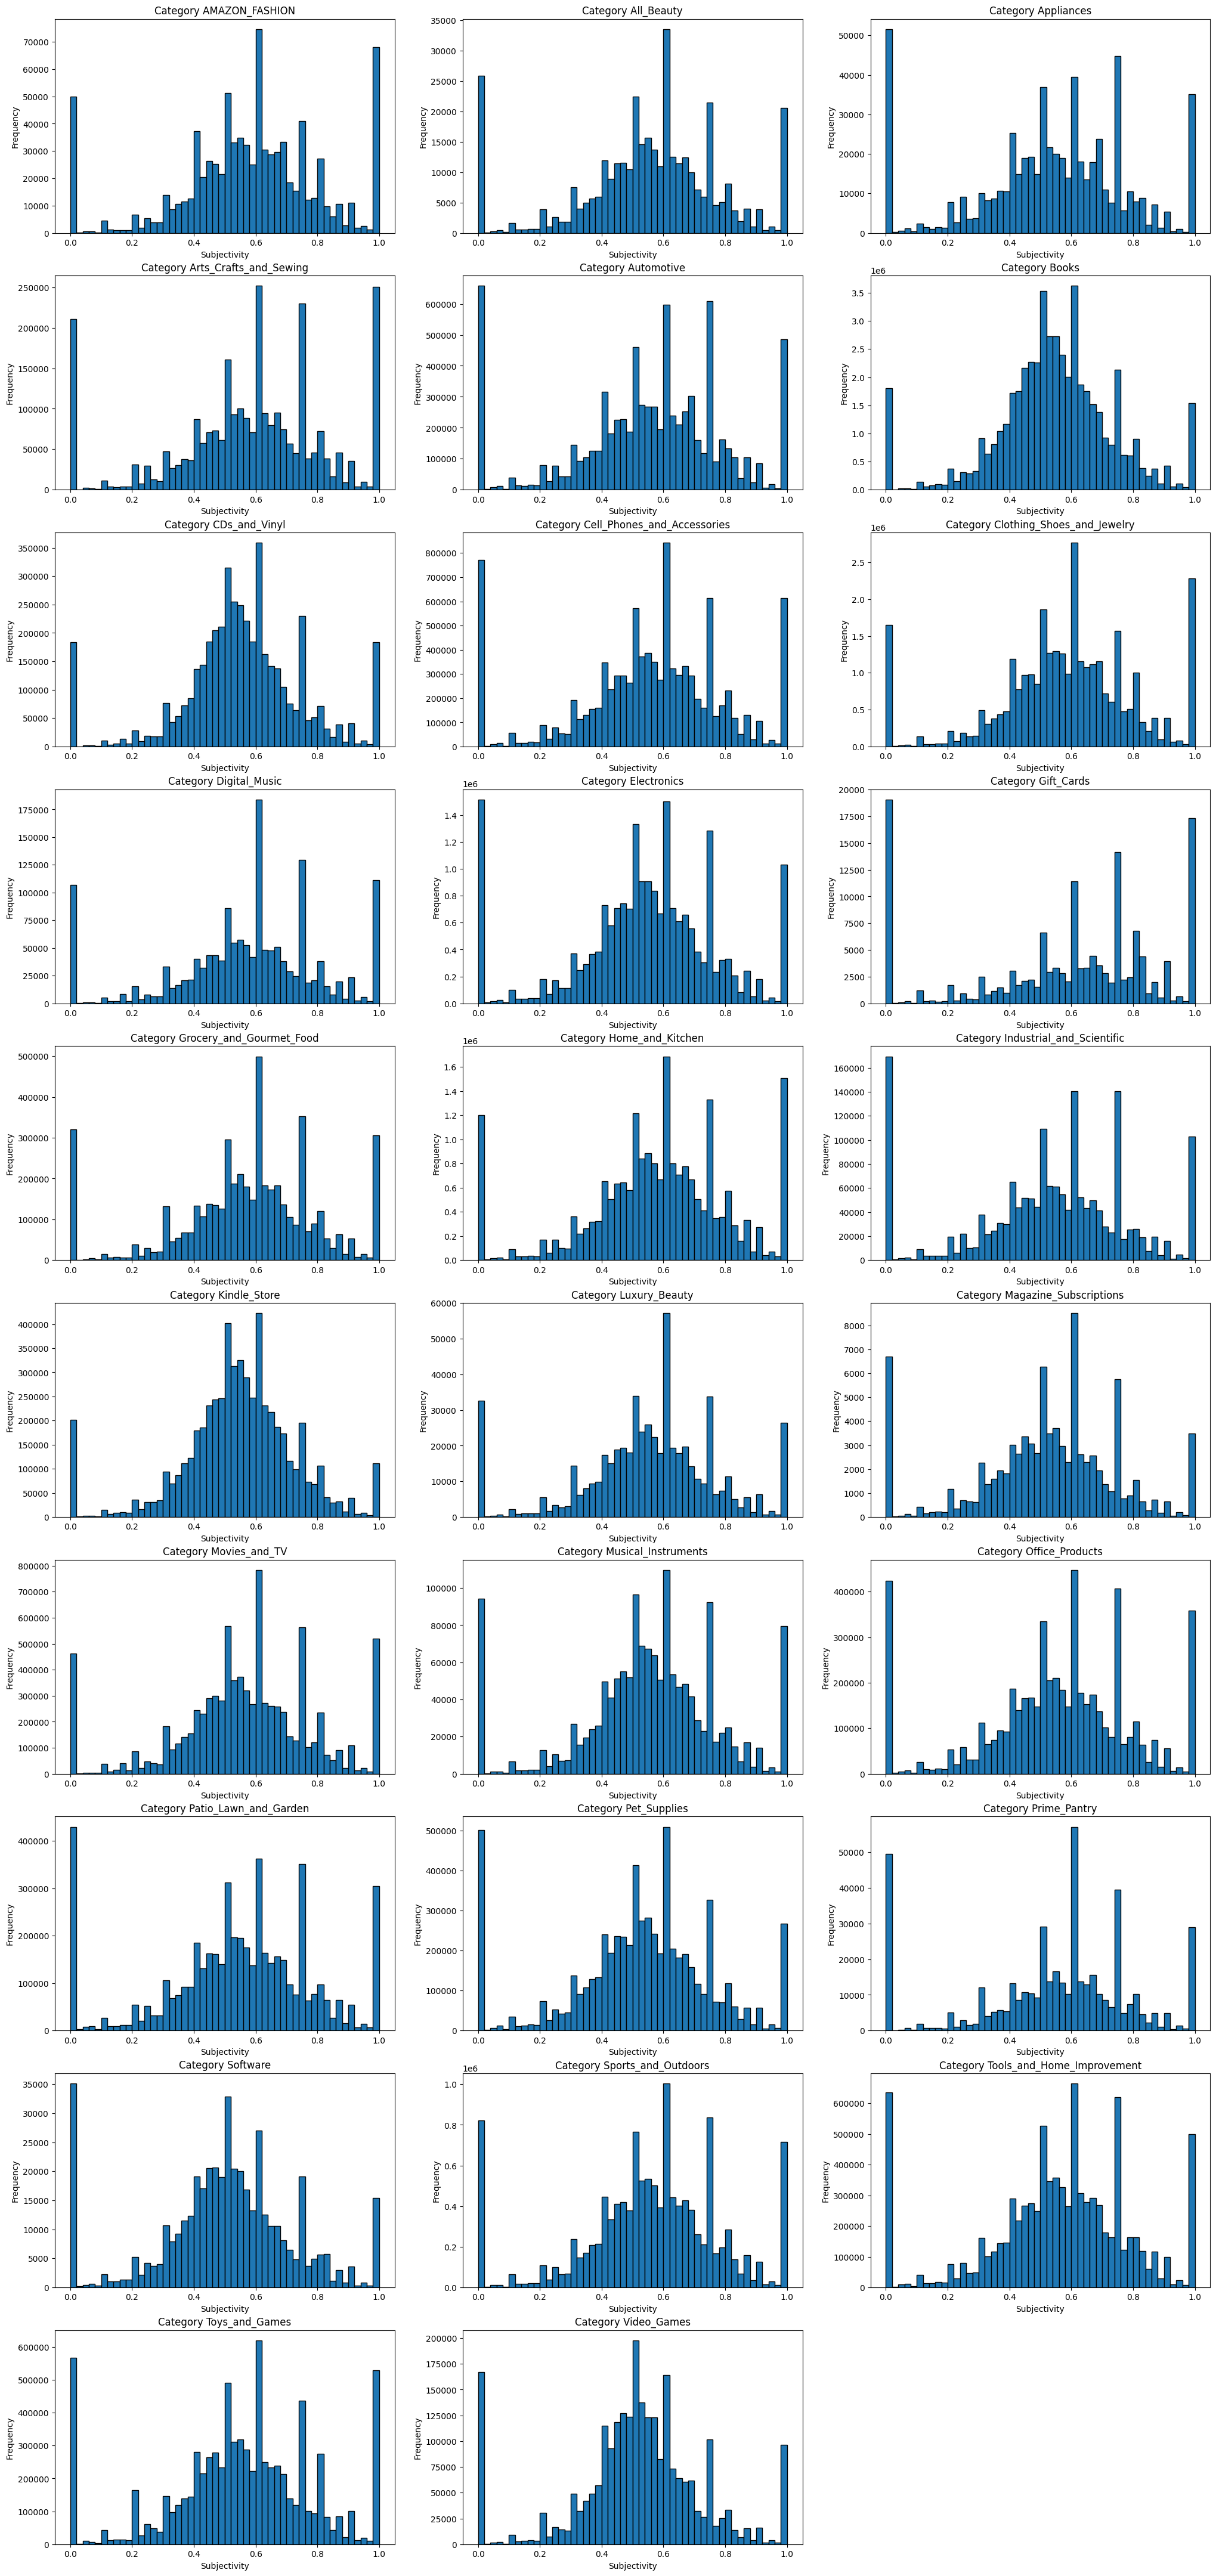

In [ ]:
plot_distributions_for_all_cat(df, "reviewText-subjectivity")

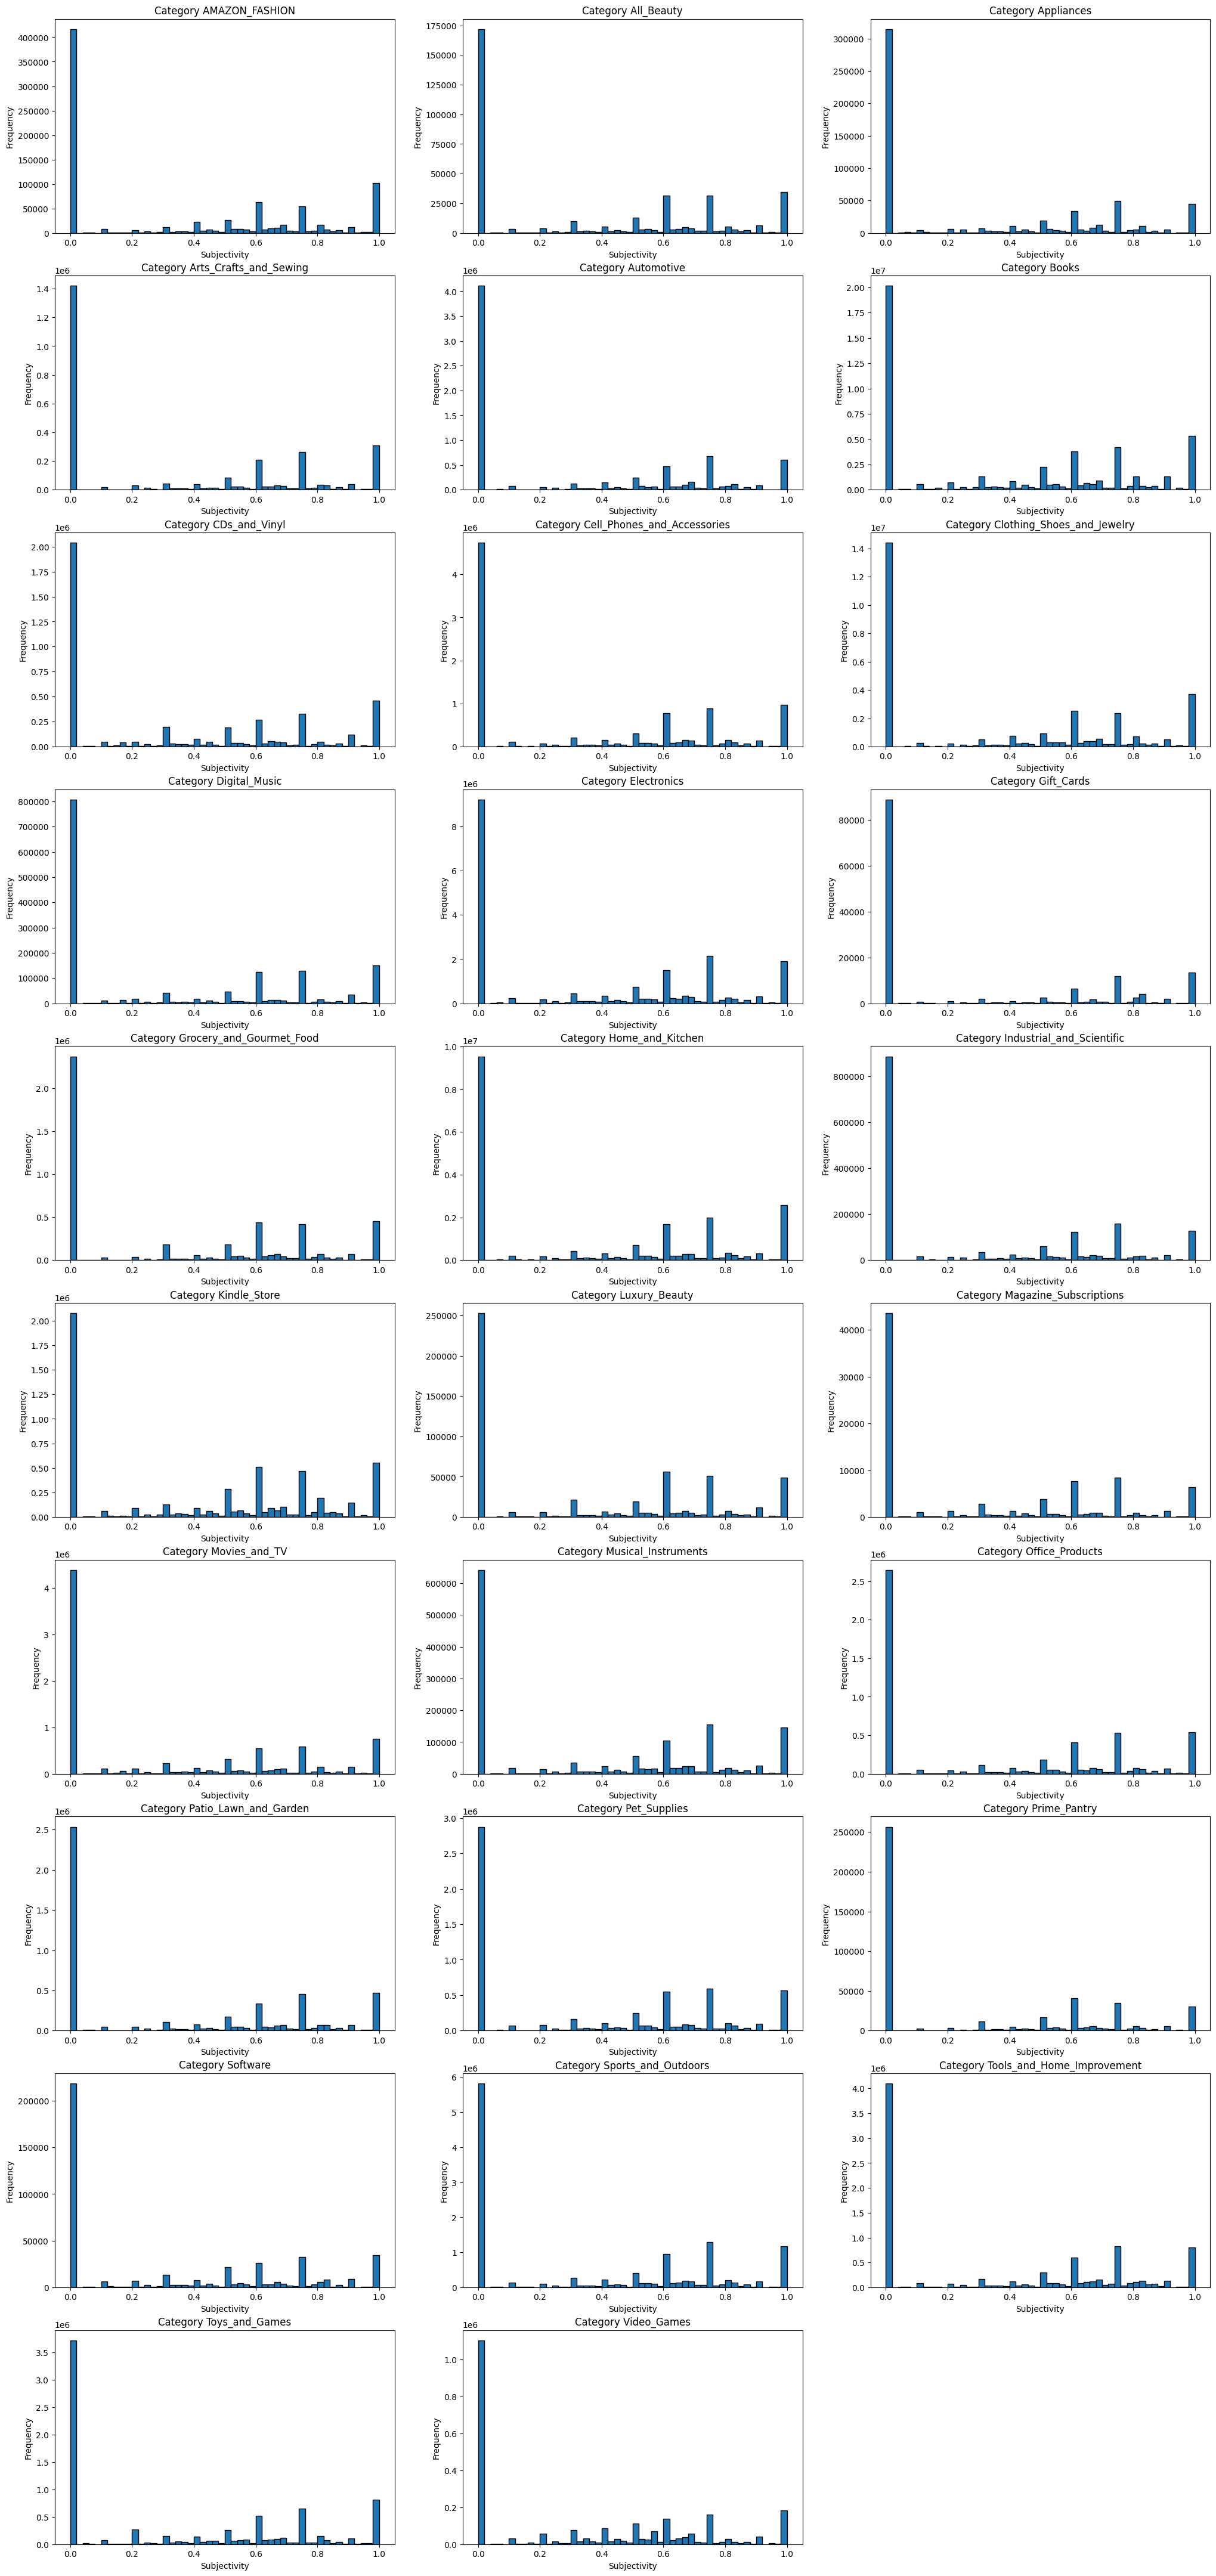

In [ ]:
plot_distributions_for_all_cat(df, "summary-subjectivity")

##### Comparison of average subjectivity
Now, lets compare the relative frequency of our classes of each category for each `reviewText` and `summary`.

In [ ]:
def plot_cat_sentiment(df, t):
    com_df_cat_sentiment = df.sort("average_subjectivity", ascending=[False]).toPandas().copy()
    sentiments = ['very_objective', 'objective', 'subjective', 'very_subjective']
    for i in range(0, 3):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]

    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[3]]

    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(x='very_subjective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very subjective')
    sns.barplot(x='subjective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='subjective')
    sns.barplot(x='objective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='objective')
    sns.barplot(x='very_objective', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very objective')

    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_subjective'], i, f'{row["average_subjectivity"]:.2f}', ha='left', va='center', color='black')

    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title(f'Subjectivity Distribution of {t} for each Category')

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.65, 0.75), title='text   Average Sentiment', alignment='left')
    
    plt.show()

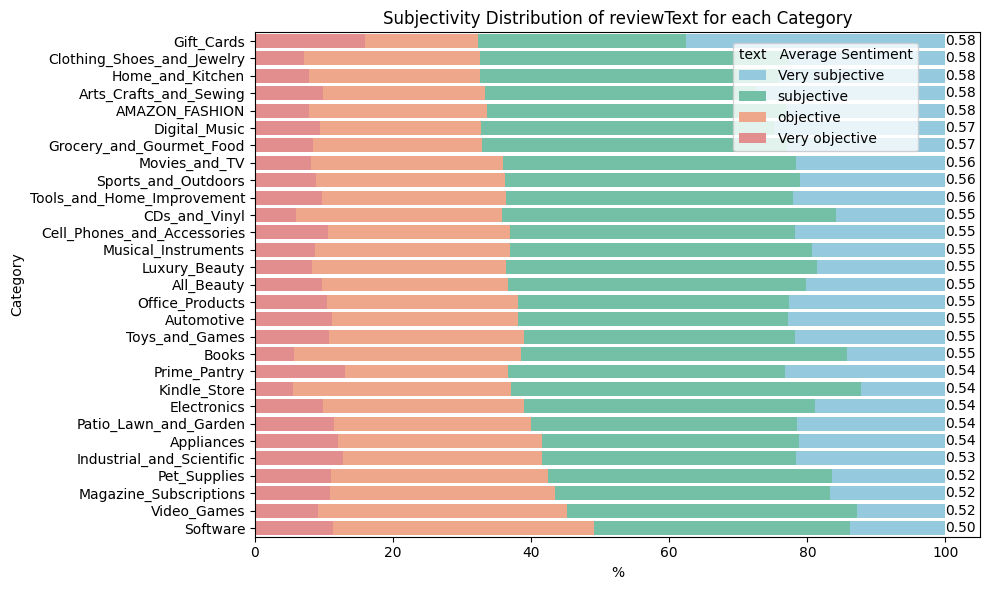

In [ ]:
plot_cat_sentiment(df_reduced_reviewText, "reviewText")

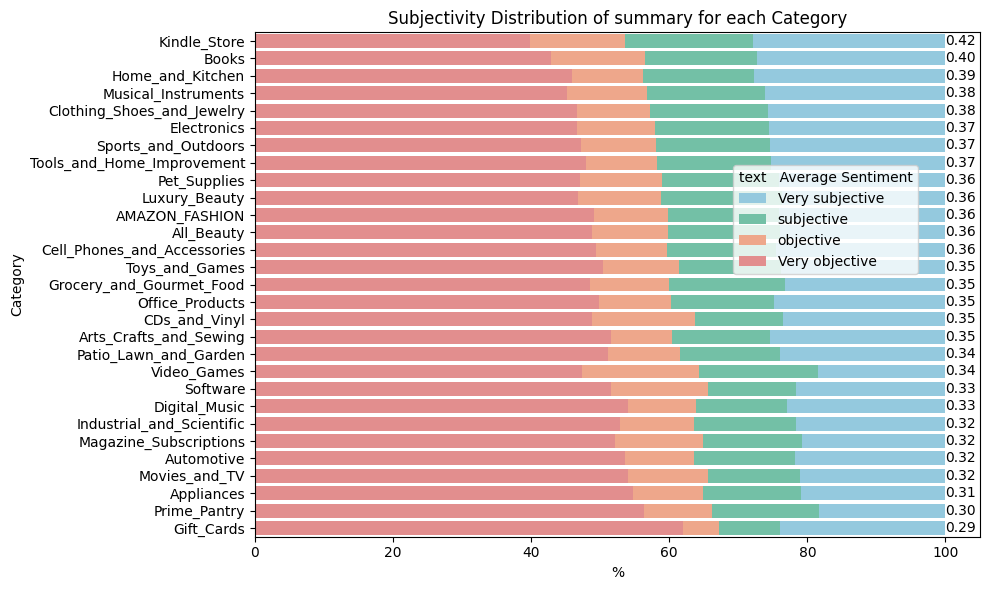

In [ ]:
plot_cat_sentiment(df_reduced_summary, "summary")

The paragraph discusses how two plots, one for `reviewText` and the other for `summary`, show different levels of subjectivity. It notes that `reviewText` tends to be more subjective overall compared to `summary`. The explanation suggests that summaries, being brief and point-based, are often more objective. The analysis of `reviewText` across different categories shows a slight difference of 0.08 between the most and least subjective categories, hinting that some categories have more subjective content. Interestingly, the distribution of very subjective and very objective content in reviewText remains similar across categories, while the distribution of objective and subjective content varies. On the other hand, the analysis of `summary` shows a consistent distribution across all four categories, with a large portion being very objective. This suggests that summaries, in general, are more objective and may not strongly influence the overall subjectivity of reviews. These findings indicate that the impact of categories on subjectivity differs between `reviewText` and `summary`.

We engage in a comparison of the minimum, average, and maximum average of subjectivity within all categories. This exploration aims to unravel the spectrum of subjectivity prevalent in each category, enabling us to discern whether particular categories tend to contain more subjective reviews. The rationale behind this analysis is to get a deeper understanding of the diversity in reviews within each category. A substantial contrast between the least and most subjective reviews within a category signifies a broad spectrum of opinions, contributing valuable insights into the dynamics of subjective expressions. Also, we're looking closely at both the `summary` and `reviewText` separately. As we notice more differences between them, it's clear they play different roles in showing how subjective reviews are. This emphasizes the need to analyze `summary` and `reviewText` carefully, recognizing their unique contributions to understanding people's opinions.

In [ ]:
def plot_min_max_average(df, t):
    min_avg = df.loc[df['average_subjectivity'].idxmin()]
    max_avg = df.loc[df['average_subjectivity'].idxmax()]
    overall_avg = df['average_subjectivity'].mean()

    _, ax = plt.subplots()

    ax.bar(f"{min_avg['category']}", min_avg['average_subjectivity'], color='#87CEEB')
    ax.bar("Average", overall_avg, color='#66CDAA')
    ax.bar(f"{max_avg['category']}", max_avg['average_subjectivity'], color='#F08080')

    plt.ylabel("Average Value")
    plt.title(f"Min, Max and Overall Averages by Category for {t}")

    plt.show()

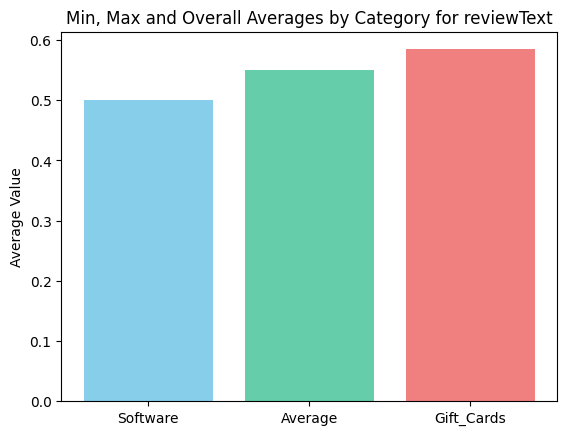

In [ ]:
plot_min_max_average(df_reduced_reviewText.toPandas(), "reviewText")

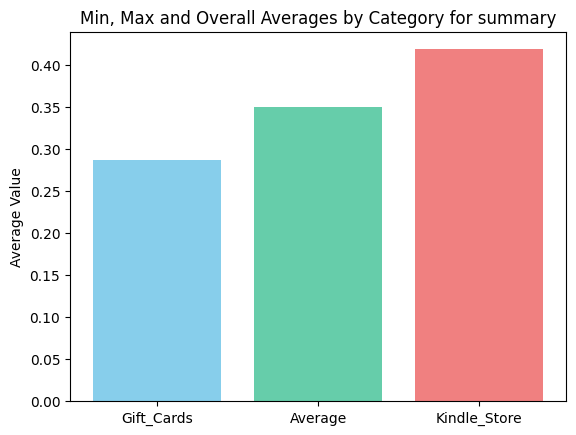

In [ ]:
plot_min_max_average(df_reduced_summary.toPandas(), "summary")

##### Final testing of the thesis
In the end, we conducted a Mann-Whitney U test on the previously discussed categories to demonstrate their significant differences. This serves as confirmation that some categories are indeed more subjective than others. To conduct a fair test, we used the entire distribution for both categories, avoiding bias introduced by the earlier set thresholds. The Mann-Whitney U test was chosen because our data does not follow a normal distribution.

As we can see in the results below, the two categories are significantly different in how subjective they are. It's crucial to highlight that this conclusion is only based on the reviewText. We mentioned before that the summary tends to be more objective, so it's not the best for figuring out the answer to this specific question.

In [ ]:
from scipy.stats import mannwhitneyu

distribution_software = df.filter(col("category") == "Software").select("reviewText-subjectivity").rdd.flatMap(lambda x: x).collect()
distribution_gift_card = df.filter(col("category") == "Gift_Cards").select("reviewText-subjectivity").rdd.flatMap(lambda x: x).collect()

_, p_value = mannwhitneyu(distribution_software, distribution_gift_card)

alpha = 0.05

if p_value < alpha:
    print(f"The two distributions are statistically significantly different, with a p-value of {p_value}")

The two distributions are statistically significantly different, with a p-value of 0.0


##### Comparison Summary vs ReviewText
In our final comparison, we examine the average subjectivity of both the `summary` and `reviewText`, reinforcing the notion that they may not consistently agree. The stark difference observed in the scale of both axes is notable, with categories like `Gift_Cards` standing out as clear outliers. This plot serves as additional evidence supporting the idea that `reviewText` should take precedence in our considerations. The disparity between `summary` and `reviewText` subjectivity underscores their distinct roles in reflecting user opinions. Relying primarily on `reviewText` ensures a more comprehensive understanding of the sentiment expressed in reviews, contributing to more accurate insights and informed decision-making for businesses.

In [ ]:
def plot_correlation_stars_sentiment(title, df_reviewText, df_summary):
    df_reviewText = df_reviewText.rename(columns={"average_subjectivity": "average_subjectivity_reviewText"})
    df_summary = df_summary.rename(columns={"average_subjectivity": "average_subjectivity_summary"})
    df_merged = df_reviewText.merge(df_summary, on='category', how='left')
    axes = sns.scatterplot(x='average_subjectivity_reviewText', y='average_subjectivity_summary', data=df_merged, color="#87CEEB")

    for _, row in df_merged.iterrows():
        axes.annotate(row['category'], (row['average_subjectivity_reviewText'], row['average_subjectivity_summary']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

    axes.set_xlabel('Average subjectivity reviewText')
    axes.set_ylabel('Average subjectivity Summary')
    axes.set_title(title)
    plt.tight_layout()
    plt.show()

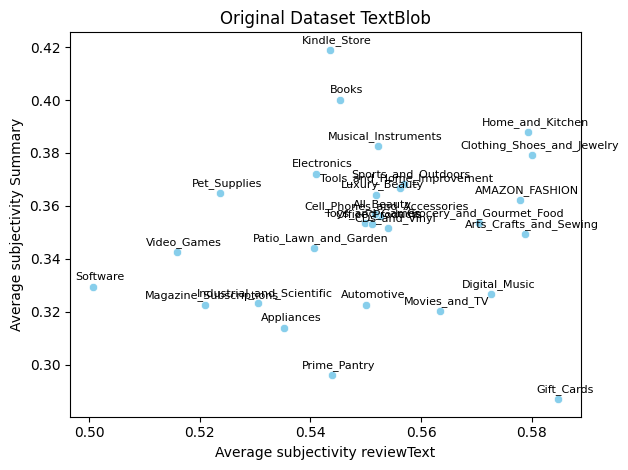

In [ ]:
plot_correlation_stars_sentiment('Original Dataset TextBlob', df_reduced_reviewText.toPandas(), df_reduced_summary.toPandas())

### 4.3 \<fill here alex\>

### 4.4 Star Rating Prediction

___To what extent can one predict the star rating from the text of a review?___

Rating a product on a scale of one star to five stars is a way of customers expressing their satisfaction with their purchase. As we have seen in the previous sections, the star rating of sales made through Amazon hold valuable information and can be used by sellers to gain insights about their products demand and quality.

However, many sellers distribute their products through multiple channels and not all of them might have the same rating system. For example, a seller could simultaniously sell their products on Amazon and on their own website. While Amazon uses a five star rating system, the seller's website provides the user only with the option to write textual reviews. In this case, it would be beneficial for the seller to be able to predict the star rating from the text of the review, in order to gain a universal rating system for all their product reviews across all channels.

In this section, we will explore the possibility of predicting the star rating from the text of a review. We will use the `summary` column in combination with the `reviewText` column of the dataset as our input and the `overall` column as our target variable. Our goal is to train a model that can predict the star rating of a review based on the text of the review, which outperforms a naive baseline model.

In [ ]:
import pyspark.pandas as ps
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier

#### Feature extraction

Most of the machine learning algorithms we will use in this section require the input data to be in a numerical format. However, the `summary` and `reviewText` columns of our dataset contain text. Therefore, we need to transform the text into numerical features. We will use the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) metric as the features we extract from the text from the text. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining. The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [ ]:
df = ps.read_parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
df['text'] = df['summary'] + ' ' + df['reviewText']
df = df[['category', 'overall', 'text']]
df: DataFrame = df.reset_index().to_spark()
df = df.dropna(subset=['text'])
df = df.sample(fraction=1e-3) # remove this line to run on whole dataset
train, test = df.randomSplit([0.9, 0.1], seed=42)

/home/tobias.grantner/.cache/pypoetry/virtualenvs/tu-dopp-ws23-OrQDfWK4-py3.9/lib/python3.9/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In order to calculate the TF-IDF values for our dataset, we first read in the values, exclude all the unneeded columns, combine the `summary` and `reviewText` columns into a single column called `text` and remove all rows that contain missing values.

Ideally we would like to use the entire dataset for training our model. However, due to time constraints, we will use a sample of the entire dataset in this section. The provided code is able to handle the entire dataset and can be used to train a model on the entire dataset, if desired.

We then split the resulting sample into a training and a test set, with a 90%/10% training and test split.

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=32)
idf = IDF(inputCol="rawFeatures", outputCol="features")

tfidf_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

Using the Spark MLib library, we can [extract the TF-IDF features](https://spark.apache.org/docs/latest/ml-features.html#tf-idf) from the text of the reviews in a distributed manner. Using a `Pipeline`, it is possible to conveniently chain together the necessary transformation steps. We opted for a total of 32 features to keep the komplexity of our models manageable.

In [ ]:
tfidf_train = tfidf_pipeline.fit(train).transform(train)
tfidf_train.write.parquet('/data/tfidf_train.parquet')

In [ ]:
tfidf_test = tfidf_pipeline.fit(test).transform(test)
tfidf_test.write.parquet('/data/tfidf_test.parquet')

We can then simply apply our TF-IDF pipeline to the training and test set and write the resulting data to parquet files for later reuse.

#### Models

We can now use this data to train different models and compare their performances. To train our models, we will use the [Spark MLib Classification](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification) module, which provides a variety of different distributed classification algorithm implementations.

In [ ]:
train = spark.read.parquet('/data/tfidf_train.parquet')
test = spark.read.parquet('/data/tfidf_test.parquet')

In [ ]:
train = train.withColumn('overall', F.col('overall') - 1)
test = test.withColumn('overall', F.col('overall') - 1)

Because some of the algorithms require the input variables to start at 0, we subtract 1 from the `overall` column of our training and test set containing the star ratings from 1 to 5.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

def evaluate(predictions, model_name):
    evaluator = MulticlassClassificationEvaluator(labelCol="overall", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol="overall", predictionCol="prediction", metricName="weightedPrecision")
    precision = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol="overall", predictionCol="prediction", metricName="weightedRecall")
    recall = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol="overall", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)

    return pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]}, index=[model_name])

The `evaluate()` function calculates the accuracy, precision, recall and F1 score of a given set of predictions.

##### Baseline

Our baseline naive model simply predicts the most common class, which is a rating of 5.

In [ ]:
baseline_prediction = test.withColumn('prediction', F.lit(4.0))

baseline_eval = evaluate(baseline_prediction, 'Baseline')
baseline_eval

,Accuracy,Precision,Recall,F1
Baseline,0.637356,0.406222,0.637356,0.496193


##### Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="overall", maxIter=10)
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

lr_eval = evaluate(lr_predictions, 'Logistic Regression')
lr_eval

24/01/22 23:08:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/01/22 23:08:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/22 23:08:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


,Accuracy,Precision,Recall,F1
Logistic Regression,0.634888,0.467366,0.634888,0.505608


##### Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="overall", featuresCol="features", numTrees=10)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

rf_eval = evaluate(rf_predictions, 'Random Forest')
rf_eval

,Accuracy,Precision,Recall,F1
Random Forest,0.637788,0.567718,0.637788,0.497188


##### Naive Bayes

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="overall", featuresCol="features")
nb_model = nb.fit(train)
nb_predictions = nb_model.transform(test)

nb_eval = evaluate(nb_predictions, 'Naive Bayes')
nb_eval

,Accuracy,Precision,Recall,F1
Naive Bayes,0.634585,0.47329,0.634585,0.501893


##### Multi Layer Perceptron (MLP)

In [ ]:
mlp = MultilayerPerceptronClassifier(labelCol="overall", featuresCol="features", maxIter=100, layers=[32, 16, 5])
mlp_model = mlp.fit(train)
mlp_predictions = mlp_model.transform(test)

mlp_eval = evaluate(mlp_predictions, 'MLP')
mlp_eval

,Accuracy,Precision,Recall,F1
MLP,0.672512,0.690259,0.672512,0.583876


#### Results

In [ ]:
pd.concat([baseline_eval, lr_eval, rf_eval, nb_eval, mlp_eval])

,Accuracy,Precision,Recall,F1
Baseline,0.637356,0.406222,0.637356,0.496193
Logistic Regression,0.634888,0.467366,0.634888,0.505608
Random Forest,0.637788,0.567718,0.637788,0.497188
Naive Bayes,0.634585,0.473290,0.634585,0.501893
Multi Layer Perceptron,0.672512,0.690259,0.672512,0.583876


From the results of our models we can see, that the accuracy of our baseline is already fairly high, with an accuracy of around 63.7%. This is due to the majority class being much more common than the other classes. However, in the precision, we can see, that the baseline model is not very good at predicting the other classes.

The Logistic Regression and the Naive Bayes models do not approve upon the flaws of the baseline model by a lot. While the accuracy is slightly lower than the baseline, the precision is higher, making the model more rounded.

The Random Forest model, having a very similar accuracy to the baseline model, does not improve in that regard either, but increases the precision even further, while not lossing much in the recall.

However, the Multi Layer Perceptron model is by far the best performing model, significantly improving across all measures. With its high precision and recall, it is able to find a good balance between the two.

#### Conclusion

With the Multi Layer Perceptron model, we were able to train a model that can predict the star rating of a review based on the text of the review fairly well and outperforms all other models. While it will not always perfectly predict the star rating of a review, it able to predict the distribution of star ratings of a set of reviews quite well. Predicting the distribution of ratings from a collection of reviews can be invaluable to a seller, indicating the general satisfaction of their customers with a product.

## 5. Final Remarks
This section summaries all findings, which were explained and discussed in the chapters above, very shortend:
- We can say that the distribution of the star ratings and sentiment ratings yield very similar outliers, indicating that those categories have a tendency of having more positive/negative reviews compared to the average.
- We can say that some categories of reviews are more subjective than others, but we have dig deep into the data to see which features are usable to do so.


## 6. Lessons Learned

This sections provides very short listing about all the things we learning during the analysis of this dataset
- Dealing with large amounts of data is hard
- Some things should work well in theory, but have their problems
- New Technology - Sentiment Analysis: TextBlob, VaderSentiment
- Sharing Computational Infrastructure between multiple contributors


## 7. Work Distribution
This section specifies which Teammember worked on which question/topic.
- Question 1: Martin Wustinger & Max Kleinegger
- Question 2: Martin Wustinger & Max Kleinegger
- Question 3: Tobias Grantner & Alex Lorenz
- Question 4: Tobias Grantner & Alex Lorenz
- Preprocessing: Tobias Grantner
- Overall we helped and discussed a lot through the exercise, furthermore shared plots and tools where applicable